<a href="https://colab.research.google.com/github/stabti/customer_lifetime_value_keras/blob/main/customer_lifetime_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Customer Lifetime Value

**Author:** [Praveen Hosdrug](https://www.linkedin.com/in/praveenhosdrug/)<br>
**Date created:** 2024/11/23<br>
**Last modified:** 2024/11/27<br>
**Updated by:** Sonia Tabti on 2025/10/21<br>
**Description:** A hybrid deep learning architecture for predicting customer purchase patterns and lifetime value.

# Prérequis
Pour pouvoir éxécuter ce notebook, allez sur colab, puis cliquez sur le menu en haut à droite pour "Modifier le type d'éxécution". Sélectionnez "Processeur", ce la sera suffisant pour ce notebook.

## Introduction

A hybrid deep learning architecture combining Transformer encoders and LSTM networks
for predicting customer purchase patterns and lifetime value using transaction history.
While many existing review articles focus on classic parametric models and traditional machine learning algorithms
,this implementation leverages recent advancements in Transformer-based models for time series prediction.
The approach handles multi-granularity prediction across different temporal scales.

## Setting up Libraries for the Deep Learning Project

In [1]:
import subprocess


def install_packages(packages):
    """
    Install a list of packages using pip.

    Args:
        packages (list): A list of package names to install.
    """
    for package in packages:
        subprocess.run(["pip", "install", package], check=True)


## List of Packages to Install

1. uciml: For the purpose of the tutorial; we will be using
          the UK Retail [Dataset](https://archive.ics.uci.edu/dataset/352/online+retail)
2. keras_hub: Access to the transformer encoder layer.

In [2]:
packages_to_install = ["ucimlrepo", "keras_hub"]

# Install the packages
install_packages(packages_to_install)

# Core data processing and numerical libraries
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras
import numpy as np
import pandas as pd
from typing import Dict


# Visualization
import matplotlib.pyplot as plt

# Keras imports
from keras import layers
from keras import Model
from keras import ops
from keras_hub.layers import TransformerEncoder
from keras import regularizers

# UK Retail Dataset
from ucimlrepo import fetch_ucirepo

## Preprocessing the UK Retail dataset

In [3]:

def prepare_time_series_data(data):
    """
    Preprocess retail transaction data for deep learning.

    Args:
        data: Raw transaction data containing InvoiceDate, UnitPrice, etc.
    Returns:
        Processed DataFrame with calculated features
    """
    processed_data = data.copy()

    # Essential datetime handling for temporal ordering
    processed_data["InvoiceDate"] = pd.to_datetime(processed_data["InvoiceDate"])

    # Basic business constraints and calculations
    processed_data = processed_data[processed_data["UnitPrice"] > 0]
    processed_data["Amount"] = processed_data["UnitPrice"] * processed_data["Quantity"]
    processed_data["CustomerID"] = processed_data["CustomerID"].fillna(99999.0)

    # Handle outliers in Amount using statistical thresholds
    q1 = processed_data["Amount"].quantile(0.25)
    q3 = processed_data["Amount"].quantile(0.75)

    # Define bounds - using 1.5 IQR rule
    lower_bound = q1 - 1.5 * (q3 - q1)
    upper_bound = q3 + 1.5 * (q3 - q1)

    # Filter outliers
    processed_data = processed_data[
        (processed_data["Amount"] >= lower_bound)
        & (processed_data["Amount"] <= upper_bound)
    ]

    return processed_data


# Load Data

online_retail = fetch_ucirepo(id=352)
raw_data = online_retail.data.features
transformed_data = prepare_time_series_data(raw_data)


def prepare_data_for_modeling(
    df: pd.DataFrame,
    input_sequence_length: int = 6,
    output_sequence_length: int = 6,
) -> Dict:
    """
    Transform retail data into sequence-to-sequence format with separate
    temporal and trend components.
    """
    df = df.copy()

    # Daily aggregation
    daily_purchases = (
        df.groupby(["CustomerID", pd.Grouper(key="InvoiceDate", freq="D")])
        .agg({"Amount": "sum", "Quantity": "sum", "Country": "first"})
        .reset_index()
    )

    daily_purchases["frequency"] = np.where(daily_purchases["Amount"] > 0, 1, 0)

    # Monthly resampling
    monthly_purchases = (
        daily_purchases.set_index("InvoiceDate")
        .groupby("CustomerID")
        .resample("M")
        .agg(
            {"Amount": "sum", "Quantity": "sum", "frequency": "sum", "Country": "first"}
        )
        .reset_index()
    )

    # Add cyclical temporal features
    def prepare_temporal_features(input_window: pd.DataFrame) -> np.ndarray:

        month = input_window["InvoiceDate"].dt.month
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        is_quarter_start = (month % 3 == 1).astype(int)

        temporal_features = np.column_stack(
            [
                month,
                input_window["InvoiceDate"].dt.year,
                month_sin,
                month_cos,
                is_quarter_start,
            ]
        )
        return temporal_features

    # Prepare trend features with lagged values
    def prepare_trend_features(input_window: pd.DataFrame, lag: int = 3) -> np.ndarray:

        lagged_data = pd.DataFrame()
        for i in range(1, lag + 1):
            lagged_data[f"Amount_lag_{i}"] = input_window["Amount"].shift(i)
            lagged_data[f"Quantity_lag_{i}"] = input_window["Quantity"].shift(i)
            lagged_data[f"frequency_lag_{i}"] = input_window["frequency"].shift(i)

        lagged_data = lagged_data.fillna(0)

        trend_features = np.column_stack(
            [
                input_window["Amount"].values,
                input_window["Quantity"].values,
                input_window["frequency"].values,
                lagged_data.values,
            ]
        )
        return trend_features

    sequence_containers = {
        "temporal_sequences": [],
        "trend_sequences": [],
        "static_features": [],
        "output_sequences": [],
    }

    # Process sequences for each customer
    for customer_id, customer_data in monthly_purchases.groupby("CustomerID"):
        customer_data = customer_data.sort_values("InvoiceDate")
        sequence_ranges = (
            len(customer_data) - input_sequence_length - output_sequence_length + 1
        )

        country = customer_data["Country"].iloc[0]

        for i in range(sequence_ranges):
            input_window = customer_data.iloc[i : i + input_sequence_length]
            output_window = customer_data.iloc[
                i
                + input_sequence_length : i
                + input_sequence_length
                + output_sequence_length
            ]

            if (
                len(input_window) == input_sequence_length
                and len(output_window) == output_sequence_length
            ):
                temporal_features = prepare_temporal_features(input_window)
                trend_features = prepare_trend_features(input_window)

                sequence_containers["temporal_sequences"].append(temporal_features)
                sequence_containers["trend_sequences"].append(trend_features)
                sequence_containers["static_features"].append(country)
                sequence_containers["output_sequences"].append(
                    output_window["Amount"].values
                )

    return {
        "temporal_sequences": (
            np.array(sequence_containers["temporal_sequences"], dtype=np.float32)
        ),
        "trend_sequences": (
            np.array(sequence_containers["trend_sequences"], dtype=np.float32)
        ),
        "static_features": np.array(sequence_containers["static_features"]),
        "output_sequences": (
            np.array(sequence_containers["output_sequences"], dtype=np.float32)
        ),
    }


# Transform data with input and output sequences into a Output dictionary
output = prepare_data_for_modeling(
    df=transformed_data, input_sequence_length=6, output_sequence_length=6
)

/tmp/ipython-input-277084066.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


## Scaling and Splitting

In [4]:

def robust_scale(data):
    """
    Min-Max scaling function since standard deviation is high.
    """
    data = np.array(data)
    data_min = np.min(data)
    data_max = np.max(data)
    scaled = (data - data_min) / (data_max - data_min)
    return scaled


def create_temporal_splits_with_scaling(
    prepared_data: Dict[str, np.ndarray],
    test_ratio: float = 0.2,
    val_ratio: float = 0.2,
):
    total_sequences = len(prepared_data["trend_sequences"])
    # Calculate split points
    test_size = int(total_sequences * test_ratio)
    val_size = int(total_sequences * val_ratio)
    train_size = total_sequences - (test_size + val_size)

    # Scale trend sequences
    trend_shape = prepared_data["trend_sequences"].shape
    scaled_trends = np.zeros_like(prepared_data["trend_sequences"])

    # Scale each feature independently
    for i in range(trend_shape[-1]):
        scaled_trends[..., i] = robust_scale(prepared_data["trend_sequences"][..., i])
    # Scale output sequences
    scaled_outputs = robust_scale(prepared_data["output_sequences"])

    # Create splits
    train_data = {
        "trend_sequences": scaled_trends[:train_size],
        "temporal_sequences": prepared_data["temporal_sequences"][:train_size],
        "static_features": prepared_data["static_features"][:train_size],
        "output_sequences": scaled_outputs[:train_size],
    }

    val_data = {
        "trend_sequences": scaled_trends[train_size : train_size + val_size],
        "temporal_sequences": prepared_data["temporal_sequences"][
            train_size : train_size + val_size
        ],
        "static_features": prepared_data["static_features"][
            train_size : train_size + val_size
        ],
        "output_sequences": scaled_outputs[train_size : train_size + val_size],
    }

    test_data = {
        "trend_sequences": scaled_trends[train_size + val_size :],
        "temporal_sequences": prepared_data["temporal_sequences"][
            train_size + val_size :
        ],
        "static_features": prepared_data["static_features"][train_size + val_size :],
        "output_sequences": scaled_outputs[train_size + val_size :],
    }

    return train_data, val_data, test_data


# Usage
train_data, val_data, test_data = create_temporal_splits_with_scaling(output)

## Evaluation

In [5]:

def calculate_metrics(y_true, y_pred):
    """
    Calculates RMSE, MAE and R²
    """
    # Convert inputs to "float32"
    y_true = ops.cast(y_true, dtype="float32")
    y_pred = ops.cast(y_pred, dtype="float32")

    # RMSE
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))

    # R² (coefficient of determination)
    ss_res = np.sum(np.square(y_true - y_pred))
    ss_tot = np.sum(np.square(y_true - np.mean(y_true)))
    r2 = 1 - (ss_res / ss_tot)

    return {"mae": np.mean(np.abs(y_true - y_pred)), "rmse": rmse, "r2": r2}


def plot_lorenz_analysis(y_true, y_pred):
    """
    Plots Lorenz curves to show distribution of high and low value users
    """
    # Convert to numpy arrays and flatten
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Sort values in descending order (for high-value users analysis)
    true_sorted = np.sort(-y_true)
    pred_sorted = np.sort(-y_pred)

    # Calculate cumulative sums
    true_cumsum = np.cumsum(true_sorted)
    pred_cumsum = np.cumsum(pred_sorted)

    # Normalize to percentages
    true_cumsum_pct = true_cumsum / true_cumsum[-1]
    pred_cumsum_pct = pred_cumsum / pred_cumsum[-1]

    # Generate percentiles for x-axis
    percentiles = np.linspace(0, 1, len(y_true))

    # Calculate Mutual Gini (area between curves)
    mutual_gini = np.abs(
        np.trapz(true_cumsum_pct, percentiles) - np.trapz(pred_cumsum_pct, percentiles)
    )

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, true_cumsum_pct, "g-", label="True Values")
    plt.plot(percentiles, pred_cumsum_pct, "r-", label="Predicted Values")
    plt.xlabel("Cumulative % of Users (Descending Order)")
    plt.ylabel("Cumulative % of LTV")
    plt.title("Lorenz Curves: True vs Predicted Values")
    plt.legend()
    plt.grid(True)
    print(f"\nMutual Gini: {mutual_gini:.4f} (lower is better)")
    plt.show()

    return mutual_gini


## Hybrid Transformer / LSTM model architecture

The hybrid nature of this model is particularly significant because it combines RNN's
ability to handle sequential data with Transformer's attention mechanisms for capturing
global patterns across countries and seasonality.

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 0.0135 - mse: 4.4448e-05 - val_loss: 0.0103 - val_mse: 2.2247e-05
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0095 - mse: 3.3019e-05 - val_loss: 0.0071 - val_mse: 5.0673e-06
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0064 - mse: 1.6896e-05 - val_loss: 0.0048 - val_mse: 4.9526e-06
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0043 - mse: 2.5514e-05 - val_loss: 0.0032 - val_mse: 3.4617e-06
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029 - mse: 1.3207e-05 - val_loss: 0.0021 - val_mse: 6.0087e-06
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019 - mse: 2.1260e-05 - val_loss: 0.0013 - val_mse: 3.9854e-06
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - mse: 1.2015e-05 - val_loss: 8.6767e-04 - val_mse: 4.6366e-06
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.9287e-04 - mse: 1.5865e-05 - val_loss: 5.5806e-04 - val_mse:

/tmp/ipython-input-1632064435.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(true_cumsum_pct, percentiles) - np.trapz(pred_cumsum_pct, percentiles)


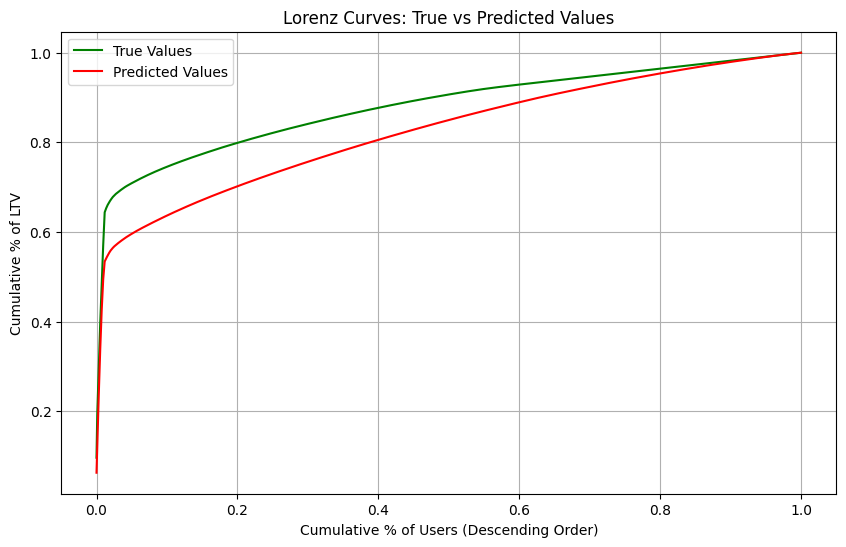

In [6]:

def build_hybrid_model(
    input_sequence_length: int,
    output_sequence_length: int,
    num_countries: int,
    d_model: int = 8,
    num_heads: int = 4,
):

    keras.utils.set_random_seed(seed=42)

    # Inputs
    temporal_inputs = layers.Input(
        shape=(input_sequence_length, 5), name="temporal_inputs"
    )
    trend_inputs = layers.Input(shape=(input_sequence_length, 12), name="trend_inputs")
    country_inputs = layers.Input(
        shape=(num_countries,), dtype="int32", name="country_inputs"
    )

    # Process country features
    country_embedding = layers.Embedding(
        input_dim=num_countries,
        output_dim=d_model,
        mask_zero=False,
        name="country_embedding",
    )(
        country_inputs
    )  # Output shape: (batch_size, 1, d_model)

    # Flatten the embedding output
    country_embedding = layers.Flatten(name="flatten_country_embedding")(
        country_embedding
    )

    # Repeat the country embedding across timesteps
    country_embedding_repeated = layers.RepeatVector(
        input_sequence_length, name="repeat_country_embedding"
    )(country_embedding)

    # Projection of temporal inputs to match Transformer dimensions
    temporal_projection = layers.Dense(
        d_model, activation="tanh", name="temporal_projection"
    )(temporal_inputs)

    # Combine all features
    combined_features = layers.Concatenate()(
        [temporal_projection, country_embedding_repeated]
    )

    transformer_output = combined_features
    for _ in range(3):
        transformer_output = TransformerEncoder(
            intermediate_dim=16, num_heads=num_heads
        )(transformer_output)

    lstm_output = layers.LSTM(units=64, name="lstm_trend")(trend_inputs)

    transformer_flattened = layers.GlobalAveragePooling1D(name="flatten_transformer")(
        transformer_output
    )
    transformer_flattened = layers.Dense(1, activation="sigmoid")(transformer_flattened)
    # Concatenate flattened Transformer output with LSTM output
    merged_features = layers.Concatenate(name="concatenate_transformer_lstm")(
        [transformer_flattened, lstm_output]
    )
    # Repeat the merged features to match the output sequence length
    decoder_initial = layers.RepeatVector(
        output_sequence_length, name="repeat_merged_features"
    )(merged_features)

    decoder_lstm = layers.LSTM(
        units=64,
        return_sequences=True,
        recurrent_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    )(decoder_initial)

    # Output Dense layer
    output = layers.Dense(units=1, activation="linear", name="output_dense")(
        decoder_lstm
    )

    model = Model(
        inputs=[temporal_inputs, trend_inputs, country_inputs], outputs=output
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mse"],
    )

    return model


# Create the hybrid model
model = build_hybrid_model(
    input_sequence_length=6,
    output_sequence_length=6,
    num_countries=len(np.unique(train_data["static_features"])) + 1,
    d_model=8,
    num_heads=4,
)

# Configure StringLookup
label_encoder = layers.StringLookup(output_mode="one_hot", num_oov_indices=1)

# Adapt and encode
label_encoder.adapt(train_data["static_features"])

train_static_encoded = label_encoder(train_data["static_features"])
val_static_encoded = label_encoder(val_data["static_features"])
test_static_encoded = label_encoder(test_data["static_features"])

# Convert sequences with proper type casting
x_train_seq = np.asarray(train_data["trend_sequences"]).astype(np.float32)
x_val_seq = np.asarray(val_data["trend_sequences"]).astype(np.float32)
x_train_temporal = np.asarray(train_data["temporal_sequences"]).astype(np.float32)
x_val_temporal = np.asarray(val_data["temporal_sequences"]).astype(np.float32)
train_outputs = np.asarray(train_data["output_sequences"]).astype(np.float32)
val_outputs = np.asarray(val_data["output_sequences"]).astype(np.float32)
test_output = np.asarray(test_data["output_sequences"]).astype(np.float32)
# Training setup
keras.utils.set_random_seed(seed=42)

history = model.fit(
    [x_train_temporal, x_train_seq, train_static_encoded],
    train_outputs,
    validation_data=(
        [x_val_temporal, x_val_seq, val_static_encoded],
        val_data["output_sequences"].astype(np.float32),
    ),
    epochs=20,
    batch_size=30,
)

# Make predictions
predictions = model.predict(
    [
        test_data["temporal_sequences"].astype(np.float32),
        test_data["trend_sequences"].astype(np.float32),
        test_static_encoded,
    ]
)

# Calculate the predictions
predictions = np.squeeze(predictions)

# Calculate basic metrics
hybrid_metrics = calculate_metrics(test_data["output_sequences"], predictions)

# Plot Lorenz curves and get Mutual Gini
hybrid_mutual_gini = plot_lorenz_analysis(test_data["output_sequences"], predictions)

## Conclusion

While LSTMs excel at sequence to sequence learning as demonstrated through the work of Sutskever, I., Vinyals,
O., & Le, Q. V. (2014) Sequence to sequence learning with neural networks.
The hybrid approach here enhances this foundation. The addition of attention mechanisms allows the model to adaptively
focus on relevant temporal/geographical patterns while maintaining the LSTM's inherent strengths in sequence learning.
This combination has proven especially effective for handling both periodic patterns and special events in time
series forecasting from Zhou, H., Zhang, S., Peng, J., Zhang, S., Li, J., Xiong, H., & Zhang, W. (2021).
Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting.